In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from ipywidgets.widgets import HTML, Output, HBox, Button, Text
from IPython.display import display, clear_output
import json
import torch

import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset, load_metric

In [71]:
pl = pipeline('summarization')

In [90]:
pl("An apple a day keeps the doctor away")

Your min_length is set to 56, but you input_length is only 10. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': " An apple a day keeps the doctor away from going to the doctor . An apple every day is an apple to keep you out of danger, says Dr. Anthony Bourdain . The doctor says apples a day is the best way to keep yourself in danger of a doctor's visit ."}]

In [36]:
num_rows = load_dataset('json', data_files='hadms_to_dis_course.json')['train'].num_rows

Using custom data configuration default-1cdec64a5269b560
Reusing dataset json (/home/k1897038/.cache/huggingface/datasets/json/default-1cdec64a5269b560/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264)


In [30]:
total_hadms = len(list(hadms_to_dis_course.keys()))

NameError: name 'hadms_to_dis_course' is not defined

In [105]:
with open('mimic_3_dataset.json', 'w') as out_file:
    with open('hadms_to_dis_course.json') as f_dis, open('hadms_to_hosp_course.json') as f_hos_course:
        d_c, h_c = f_dis.readline(), f_hos_course.readline()
        while d_c:
            d_c, h_c = json.loads(d_c), json.loads(h_c)
            line = {'hadm_id': d_c['hadm_id'], 'summary': d_c['text'], 'text': h_c['text']}
            out_file.write(json.dumps(line))
            d_c, h_c = f_dis.readline(), f_hos_course.readline()        

In [42]:
rng = np.arange(num_rows)
np.random.shuffle(rng)

In [49]:
last_train_idx = int(np.ceil(0.8 * num_rows))
train_idxs = rng[0:last_train_idx]
last_val_idx = int(np.ceil(0.1 * num_rows))
val_idxs = rng[last_train_idx:last_val_idx]
test_idxs = rng[last_val_idx:]

In [78]:
np.average([len(n) for n in notes['train']['summary']])

2699.7647390044003

In [73]:
[len(data_file[i]['summary']) for i in train_idxs]

TypeError: '_io.TextIOWrapper' object is not subscriptable

In [71]:
with open('mimic_3_dataset.json') as data_file, \
        open('mimic_3_train.json', 'w') as train_file, \
        open('mimic_3_val.json', 'w') as val_file, \
        open('mimic_3_test.json', 'w') as test_file:
    for i in range(num_rows):
        line = data_file.readline()
        if i in train_idxs:
            train_file.write(line)
        elif i in val_idxs:
            val_file.write(line)
        elif i in test_idxs:
            test_file.write(line)

In [9]:
notes = load_dataset('json', data_files='mimic_3_dataset.json', cache_dir=None)

Using custom data configuration default-b1b6223c4140dad3
Reusing dataset json (/home/k1897038/.cache/huggingface/datasets/json/default-b1b6223c4140dad3/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264)


In [4]:
rouge = load_metric('rouge')

In [5]:
model = 't5-small'
# model = 'EleutherAI/gpt-neo-1.3B'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model, use_fast=True)

In [29]:
notes['hadm_id']

DatasetDict({
    train: Dataset({
        features: ['hadm_id', 'summary', 'text'],
        num_rows: 47951
    })
})

In [115]:
notes

DatasetDict({
    train: Dataset({
        features: ['hadm_id', 'summary', 'text'],
        num_rows: 47951
    })
})

In [123]:
def preprocess_texts(ds, is_t5=False):
    examples = ds['text']
    if is_t5:
        examples = ['summarize: ' + e for e in examples]
    summaries = ds['summary']
    model_inputs = tokenizer(examples)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(summaries)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
notes_tokd = notes['train'].map(preprocess_texts, num_proc=5)

In [11]:
encodings = tokenizer(notes['train']['text']) 

Token indices sequence length is longer than the specified maximum sequence length for this model (10894 > 512). Running this sequence through the model will result in indexing errors


In [15]:
lens = [len(encodings[e]) for e in range(len(encodings['input_ids']))]

In [23]:
# drop tok lens over 10k
sample_lens = [len(encodings[e]) for e in range(len(encodings['input_ids'])) if len(encodings[e]) < 15000]

In [24]:
len(sample_lens) / len(lens)

0.8924318575212196

In [25]:
np.histogram(sample_lens, bins=10)

(array([ 2844, 11559, 11556,  6447,  3655,  2293,  1592,  1210,   919,
          718]),
 array([  170. ,  1652.6,  3135.2,  4617.8,  6100.4,  7583. ,  9065.6,
        10548.2, 12030.8, 13513.4, 14996. ]))

<AxesSubplot:ylabel='Count'>

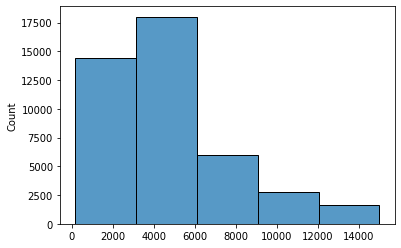

In [26]:
sns.histplot(sample_lens, stat='count', bins=5)